
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `Gyu Hwan Park `

**Student ID(s):**     `998174 `


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import log
%matplotlib inline               
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [2]:
"""
Function used within 'preprocess()'.
Returns a list that contains the attribute type of each individual column.
    * 0 : Nominal
    * 1 : Ordinal
    * 2 : Numeric
    
    Input arguments:
    
    * data: preprocessed input dataframe
    * data_type: type of the original dataset provided in README ("numeric", "ordinal", "nominal", "mixed")
    * filename: name of the input file (e.g. "university.data") 
"""
def list_attr_types(data, data_type, filename):
    attr_types = []
    if data_type == "nominal":    
        attr_types = [0 for i in range(data.shape[1] - 1)]
    elif data_type == "ordinal":
        attr_types = [1 for i in range(data.shape[1] - 1)]
    elif data_type == "numeric":
        attr_types = [2 for i in range(data.shape[1] - 1)]
        
    # Hard code attribute types for mixed datasets as given in README
    elif data_type == "mixed":
        if filename == "adult.data":
            attr_types = [2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0]
        elif filename == "bank.data":
            attr_types = [2, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0]
        elif filename == "university.data":
            attr_types = [0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0]
            
    return attr_types

In [3]:
"""
Function used within 'preprocess()' for Question 1.
Discretise numeric valued attributes using K-Means algorithm.
Returns nothing.

    Input arguments:
    * data: dataset to preprocess
    * attr_list: attribute types list
    * num_cluster: K-value for K-means
"""
def numeric_to_discrete(data, attr_list, num_cluster):
    
    for i in range(len(attr_list)):
        if attr_list[i] == 2:
            
            # impute NaN values with the column mean to proceed with K-Means Clustering
            data.iloc[:,i].fillna((data.iloc[:,i].mean()), inplace=True)

            # Use K-means clustering algorithm to discretise numeric columns
            column = np.array(data.iloc[:,i]).reshape(-1, 1)
            kmeans = KMeans(n_clusters = num_cluster, random_state = 100).fit(column)
            entries = kmeans.labels_
            data.iloc[:,i] = entries
            
            attr_list[i] = 0
    return

In [4]:
# This function should prepare the data by reading it from a file and converting 
# it into a useful format for training and testing

""" 
Preprocess input csv file into a universal format for training and testing.
    * Input arguments:
    
    * filename: the name of the csv file to be opened
    * data_type: must take one value out of 4 string values, "nominal", "ordinal", "numeric" or "mixed"
        * "nominal" : all attributes of input data are of nominal type
        * "ordinal" : all attributes of input data are of ordinal type
        * "numeric" : all attributes of input data are of numeric type
        * "mixed" : input data has a mixture of above attribute types
        
    * class_loc: takes the location (column number) of the class column
        * -1 : class is the last column (default argument)
        * 1 : first column
        * 2 : second column ... etc.
    * missing_value: takes in the exact symbol of the missing values in the dataset
        * None : no missing values in the dataset (default argument)
        * '?' : missing values are represented as '?'
        * 0 : missing values are represented as 0 ... etc.
    * contains_id: takes 'True' or 'False' boolean values
        * True : dataset contains an ID column (in the 1st column always)
        * False: dataset does not contain an ID column
    * Num_k: takes integer values for the number of groups in the numeric valued column for discretisation
        
    * Assumptions:
        * There is only one class label for each dataset
        * Missing values are represented by only one common symbol in each individual dataset
        * ID columns are all in the first column
"""

def preprocess(filename, data_type, class_loc = -1, missing_value = None, contains_id = None, num_k = None):
    
    # Read in data file
    df = pd.read_csv(filename, header = None)
    
    # Replace missing values with NaN
    if missing_value is not None:
        df.replace(missing_value, np.nan, inplace=True)
    
    # Remove id columns which are not attributes (All id's in these datasets are first columns)
    if contains_id is not None:
        df.drop(0, axis=1, inplace=True)
        
    # Move the class (label) column to the last column if it is not already
    if class_loc != -1:
        columns = list(df)
        # Move the desired class column to the last column of the df
        # 'class_loc - 1': - 1 there because input paramter 'class_loc' is the nth column in human sense 
        columns.insert(len(columns) - 1, columns.pop(columns.index(class_loc - 1)))
        # Reordering all values
        df = df.loc[:, columns]

        
    # make a list for attribute types of this dataset
    attr_types = list_attr_types(df, data_type, filename) 
    
    # discretise numeric attributes using K-Means algorithm and update attr_types
    if num_k is not None:
        numeric_to_discrete(df, attr_types, num_k)
    
    # return the preprocessed dataframe and attribute types list
    return df, attr_types

In [5]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

"""
Train the input train_set dataframe by calculating the priors and likelihoods.

    * train_set: preprocessed dataset, which is the first element of the return value of preprocess()
    * attr_type: list of attribute types, second element of preprocess()
    
    * Assumptions:
    * We handle both ordinal and nominal as discrete data, and numeric as non-discrte
"""

def train(train_set, attr_types):
    
    set_size = train_set.shape[0]
    priors = {}
    # Can retrieve specific values by likelihoods[class][attribute][value]
    likelihoods = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    # Last column of train_set is the class column
    class_col = train_set.iloc[:, train_set.shape[1] - 1]

    # Calculate priors by going through the class column
    # Go through each of the class labels
    for class_lbl in set(class_col):
        
        # Calculate priors
        priors[class_lbl] = len(class_col[class_col == class_lbl]) / float(set_size)
        
        # Iterate across each attribute of the dataset
        attr_index = 0
        for attribute in train_set.columns[:-1]:
            
            # if column is numeric, we calculate the mean and standard deviation
            if attr_types[attr_index] == 2:
                mean = np.nanmean(train_set[attribute][class_col == class_lbl])
                std_dev = np.nanstd(train_set[attribute][class_col == class_lbl])
                likelihoods[class_lbl][attribute] = (mean, std_dev)
                
            # if column is non-numeric (i.e. discrete), calculate likelihoods
            else:
                temp = train_set.loc[class_col == class_lbl, [attribute, train_set.columns[-1]]]
                temp_size = len(temp)

                count = defaultdict(int)
                for i in temp[attribute]:
                    if not pd.isnull(i):
                        count[i] += 1

                for i in count:
                    likelihoods[class_lbl][attribute][i] = count[i] / temp_size
            attr_index += 1
            
    trained_model = {"priors": priors, "likelihoods": likelihoods}
    
    # return the trained model, a dict containing priors and likelihoods of the dataset
    return trained_model

In [6]:
"""
Function for calculating the pdf value at x, from a normal distribution with input mean and sd
Retrieved from:
https://stackoverflow.com/questions/12412895/calculate-probability-in-normal-distribution-given-mean-std-in-python
"""

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2 * math.pi * var)**.5
    num = math.exp(-(float(x) - float(mean))**2 / (2*var))
    return num / denom

In [7]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

"""
Predicts the label of all instances in testing_set.
Returns a dictionary of predicted labels with integer instance key.

    * 'trained_model' takes in the dictionary of priors, likelihoods returned by train()
    * 'testing_set' takes in preprocessed dataset to test the trained model on
    * 'attr_types' takes the attribuet types list
    * question_two' takes 'True' or 'False' depending on whether predict() is run for Question 2 or not
"""

def predict(trained_model, testing_set, attr_types, question_two = False):
    
    priors = trained_model["priors"]
    likelihoods = trained_model["likelihoods"]
    
    # Store likelihood values for all possible classes for a single instance
    # Will have the form {class A: 0.654, class B: 0.002, ...}
    single_prediction = {}
    
    # Final Prediction dictionary of the form {row 1: class Z, row 2: class X, row 3: class Z, ...}
    all_predictions = {}
    
    # Delete the class label column (last column) from test set and store attributes and true labels separately
    test_classes = testing_set.iloc[:, testing_set.shape[1] - 1]
    test_data = testing_set.drop(testing_set.columns[-1], axis = 1)
    
    columns = testing_set.columns    
    test_size = len(test_classes)
    
    # For epsilon-smoothing
    epsilon = 1.0/10000
    
    # Go down the dataframe (iterate thru all instances)
    for i in range(test_size):
        
        instance = test_data.iloc[i, :]
        
        # For each class
        for class_lbl in priors.keys():     
            
            # Calculate the first term of posterior probablity
            posterior_prob = log(priors[class_lbl], 2)
            
            if question_two == False:
            ################################ This section only runs if not question 2 #######################
                attr_index = 0
                for attribute in columns:
                    try:
                        # Proceed if attribute value of an instance exists (i.e. not missing)
                        if not pd.isnull(instance[attribute]):
                            # non-numeric attribute
                            if attr_types[attr_index] != 2:
                                posterior_prob += log(likelihoods[class_lbl][attribute][instance[attribute]], 2)
                            # numeric attribute, use normal pdf to calculate posterior
                            else:
                                mean = likelihoods[class_lbl][attribute][0]
                                std_dev = likelihoods[class_lbl][attribute][-1]
                                posterior_prob += log(normpdf(instance[attribute], mean = mean, sd = std_dev), 2)
                        else:
                            # ignore if value is missing
                            pass
                    except:
                        # use epsilon-smoothing method when we cannot find corresponding likelihood in our trained model
                        posterior_prob += log(epsilon, 2)
                    attr_index += 1
            ################################ This section only runs if not question 2 #######################

            single_prediction[class_lbl] = posterior_prob
                    
        # Get the class with highest probability based on our model
        all_predictions[i] = max(single_prediction, key=single_prediction.get)
    
    # Return the prediction dictionary
    return all_predictions

In [8]:
# This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

"""
Evaluate our prediction.
Return a tuple of (accuracy, confusion matrix)

    * predicted_classes: returned predicted labels by predict()
    * true_classes: true class column from test set
"""

def evaluate(predicted_classes, true_classes):
    
    # need to check if prediction is correct for each instance
    check = (list(predicted_classes.values()), true_classes)
    
    acc = 0
    for i in range(len(check[0])):
        # Sum the number of instances of correct predictions
        acc += int(check[0][i] == check[1][i])
    # Divide by total size to get accuracy percentage
    acc = 1.0 * acc / len(check[0])    
    
    y_actu = pd.Series(list(predicted_classes.values()), name='Actual')
    y_pred = pd.Series(list(true_classes), name='Predicted')
    
    # Make confusion matrix
    unique_label = np.unique([y_actu, y_pred])
    conf_matrix = pd.DataFrame(confusion_matrix(y_actu, y_pred, labels=unique_label), 
                        index=['true:{:}'.format(x) for x in unique_label], 
                        columns=['pred:{:}'.format(x) for x in unique_label])
    
    # Return accuracy value and confusion matrix
    return acc, conf_matrix

In [9]:
"""
Simple helper function to use when actually running evaluate()
Returns the last (class) column of input dataset

    * data: any dataset
"""
def get_class_col(data):
    return data.iloc[:, data.shape[1] - 1]

#### E.g.) Perform Preprocess to Evaluate on 'mushroom' dataset (<15 sec)

In [11]:
mushroom_preprocessed = preprocess("mushroom.data", "nominal", class_loc = 1, missing_value = '?')
mushroom_trained = train(mushroom_preprocessed[0], mushroom_preprocessed[1])
mushroom_predict = predict(mushroom_trained, mushroom_preprocessed[0], mushroom_preprocessed[-1], question_two = False)
mushroom_eval = evaluate(mushroom_predict, get_class_col(mushroom_preprocessed[0]))

In [12]:
mushroom_eval[0]

0.9654111275233875

In [13]:
mushroom_eval[1]

,pred:e,pred:p
true:e,4188,261
true:p,20,3655


### Running the NB classifier on all datasets

### 1. Preprocess all Datasets

In [99]:
# nominal attributes datasets
breast_preprocessed = preprocess("breast-cancer-wisconsin.data", "nominal", missing_value = '?', contains_id = True)
mushroom_preprocessed = preprocess("mushroom.data", "nominal", class_loc = 1, missing_value = '?')
lymphography_preprocessed = preprocess("lymphography.data", "nominal", class_loc = 1)

# numeric attributes datasets
wdbc_preprocessed = preprocess("wdbc.data", "numeric", class_loc = 2, contains_id = True)
wine_preprocessed = preprocess("wine.data", "numeric", class_loc = 1)

# ordinal attributes datasets
car_preprocessed = preprocess("car.data", "ordinal")
nursery_preprocessed = preprocess("nursery.data", "ordinal")
somerville_preprocessed = preprocess("somerville.data", "ordinal", class_loc = 1)

# mixed attributes datasets
adult_preprocessed = preprocess("adult.data", "mixed", missing_value ='?')
bank_preprocessed = preprocess("bank.data", "mixed")
uni_preprocessed = preprocess("university.data", "mixed", contains_id=True, class_loc=15, missing_value=0)

# [(df1, attr_types1), (df2, attr_types2), (df3, attr_types3), ...]
# List of preprocessed datasets for convenience
preprocessed_files = [breast_preprocessed, mushroom_preprocessed, lymphography_preprocessed, 
                      wdbc_preprocessed, wine_preprocessed,
                      car_preprocessed, nursery_preprocessed, somerville_preprocessed,
                      adult_preprocessed, bank_preprocessed, uni_preprocessed]

### 2. Train, Predict and Evaluate all datasets 

In [100]:
trained_sets = []
predicted_sets = []
eval_sets = []

for train_set, attr_type in preprocessed_files:
    trained_item = train(train_set, attr_type)
    trained_sets += [trained_item]
    predicted_item = predict(trained_item, train_set, attr_type)
    predicted_sets += [predicted_item]
    eval_sets += [evaluate(predicted_item, get_class_col(train_set))]


acc_dictionary = {'breast': eval_sets[0][0],
                  'mushroom': eval_sets[1][0],
                  'lymphography': eval_sets[2][0],
                  'wdbc': eval_sets[3][0],
                  'wine': eval_sets[4][0],
                  'car': eval_sets[5][0],
                  'nursery':eval_sets[6][0],
                  'somerville':eval_sets[7][0],
                  'adult':eval_sets[8][0],
                  'bank':eval_sets[9][0],
                  'uni': eval_sets[10][0]}

result = pd.DataFrame(list(acc_dictionary.items()), columns = ['Data', 'NB Accuracy']).set_index('Data')

conf_matrix_dict = {'breast': eval_sets[0][1],
                  'mushroom': eval_sets[1][1],
                  'lymphography': eval_sets[2][1],
                  'wdbc': eval_sets[3][1],
                  'wine': eval_sets[4][1],
                  'car': eval_sets[5][1],
                  'nursery':eval_sets[6][1],
                  'somerville':eval_sets[7][1],
                  'adult':eval_sets[8][1],
                  'bank':eval_sets[9][1],
                  'uni': eval_sets[10][1]}

#### E.g.) Accessing confusion matrix for 'car' datatset

In [101]:
conf_matrix_dict['car']

,pred:acc,pred:good,pred:unacc,pred:vgood
true:acc,289,46,47,26
true:good,10,21,2,0
true:unacc,85,0,1161,0
true:vgood,0,2,0,39


#### NB Accuracy for all datasets

In [102]:
result

,NB Accuracy
Data,
breast,0.975680
mushroom,0.965411
lymphography,0.891892
wdbc,0.940246
wine,0.988764
car,0.873843
nursery,0.903086
somerville,0.671329
adult,0.828169


In [25]:
result_kmeans = result.loc[['wdbc', 'wine', 'adult', 'bank', 'uni'],:]
result_kmeans

,Accuracy
Data,
wdbc,0.940246
wine,0.988764
adult,0.828169
bank,0.877065
uni,0.805195


### QUESTION 1. Perform Preprocess to Evaluate with K-means algorithm, K $\in [2,10]$

In [26]:
for num_k in range(2, 11):

    # numeric attributes datasets
    wdbc_preprocessed = preprocess("wdbc.data", "numeric", class_loc = 2, contains_id = True, num_k = num_k)
    wine_preprocessed = preprocess("wine.data", "numeric", class_loc = 1, num_k = num_k)

    # mixed attributes datasets
    adult_preprocessed = preprocess("adult.data", "mixed", missing_value ='?', num_k = num_k)
    bank_preprocessed = preprocess("bank.data", "mixed", num_k = num_k)
    uni_preprocessed = preprocess("university.data", "mixed", contains_id=True, class_loc=15, missing_value=0, 
                                  num_k = num_k)

    # [(df1, attr_types1), (df2, attr_types2), (df3, attr_types3), ...]
    preprocessed_files = [wdbc_preprocessed, wine_preprocessed,
                          adult_preprocessed, bank_preprocessed, uni_preprocessed]

    trained_sets = []
    predicted_sets = []
    eval_sets = []

    for train_set, attr_type in preprocessed_files:
        trained_item = train(train_set, attr_type)
        trained_sets += [trained_item]
        predicted_item = predict(trained_item, train_set, attr_type)
        predicted_sets += [predicted_item]
        eval_sets += [evaluate(predicted_item, get_class_col(train_set))]

    acc_dictionary_k = {'wdbc': eval_sets[0][0],
                      'wine': eval_sets[1][0],
                      'adult':eval_sets[2][0],
                      'bank':eval_sets[3][0],
                      'uni': eval_sets[4][0]}
    
    conf_matrix_dict_k = {'wdbc': eval_sets[0][1],
                  'wine': eval_sets[1][1],
                  'adult':eval_sets[2][1],
                  'bank':eval_sets[3][1],
                  'uni': eval_sets[4][1]}
        
    result_kmeans['k=%d Accuracy'%num_k] = list(acc_dictionary_k.values())

In [28]:
result_kmeans

,Accuracy,k=2 Accuracy,k=3 Accuracy,k=4 Accuracy,k=5 Accuracy,k=6 Accuracy,k=7 Accuracy,k=8 Accuracy,k=9 Accuracy,k=10 Accuracy
Data,,,,,,,,,,
wdbc,0.940246,0.938489,0.942004,0.945518,0.947276,0.945518,0.952548,0.947276,0.950791,0.945518
wine,0.988764,0.943820,0.971910,0.988764,1.000000,0.994382,0.983146,0.994382,0.994382,1.000000
adult,0.828169,0.813611,0.822702,0.823470,0.821719,0.823992,0.824637,0.825036,0.825435,0.825865
bank,0.877065,0.890867,0.886687,0.885139,0.884563,0.884364,0.885271,0.882418,0.882307,0.881732
uni,0.805195,0.818182,0.822511,0.822511,0.848485,0.844156,0.826840,0.844156,0.848485,0.831169


In [94]:
# find best k and best performance

k_value_choice = pd.DataFrame(result_kmeans.idxmax(axis=1))
k_value_choice.columns = ['K-value']

result_max = result_kmeans.max(axis=1)
result_max = pd.DataFrame(result_max)
result_max.columns = ['Best Performance']

result_max = pd.DataFrame(result_kmeans.iloc[:, 0]).join(result_max)
result_max = result_max.join(k_value_choice)

In [115]:
result_max

,NB Accuracy,Best Performance,K-value
Data,,,
wdbc,0.940246,0.952548,k=7 Accuracy
wine,0.988764,1.000000,k=5 Accuracy
adult,0.828169,0.828169,NB Accuracy
bank,0.877065,0.890867,k=2 Accuracy
uni,0.805195,0.848485,k=5 Accuracy


#### Examine distribution of attribute values

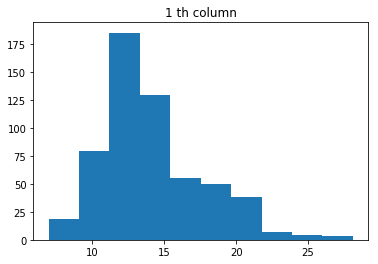

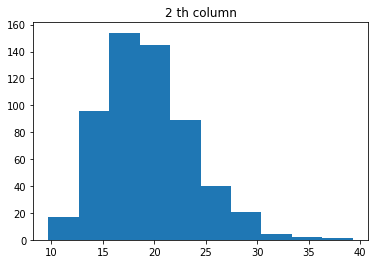

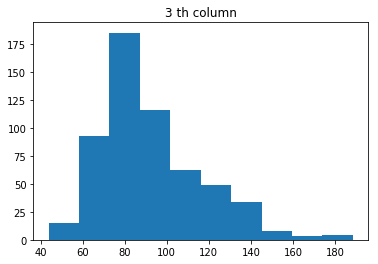

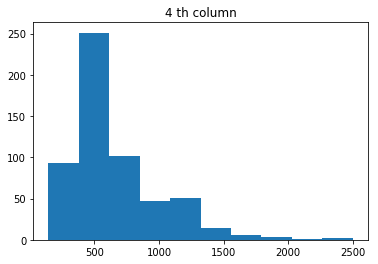

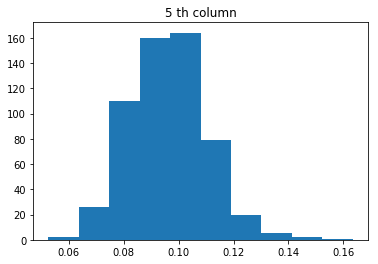

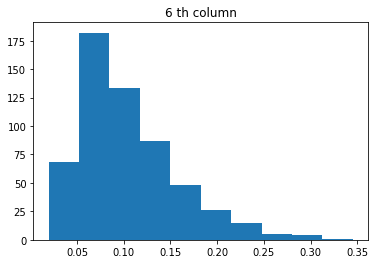

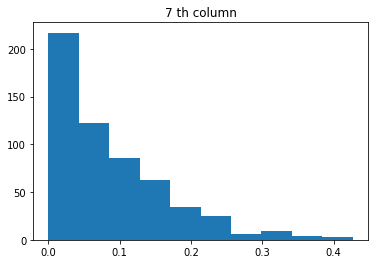

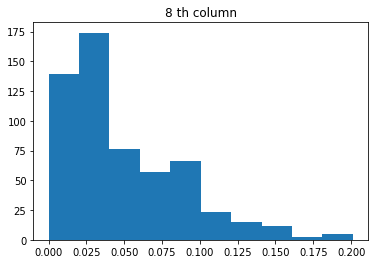

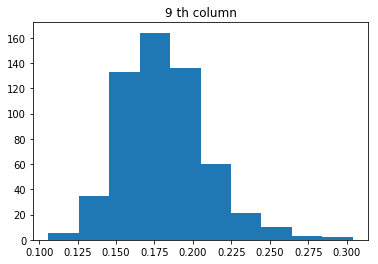

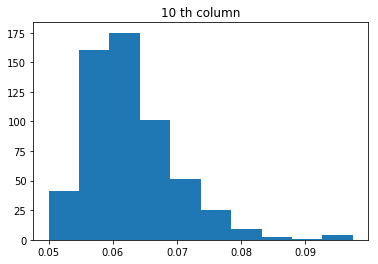

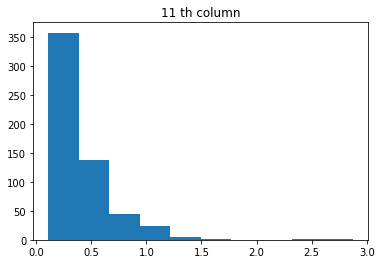

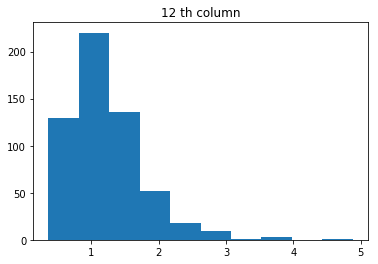

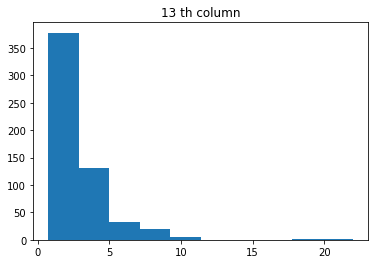

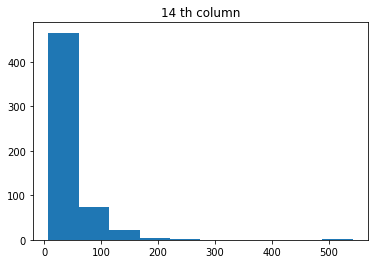

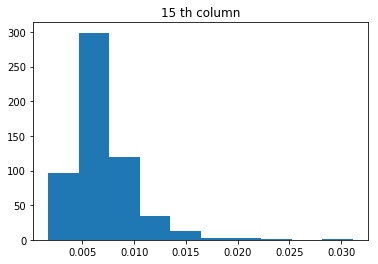

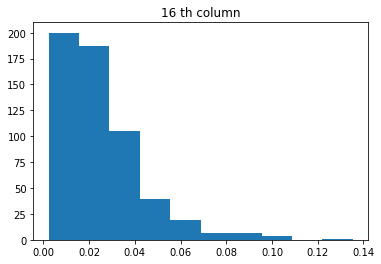

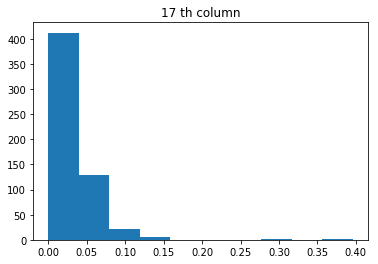

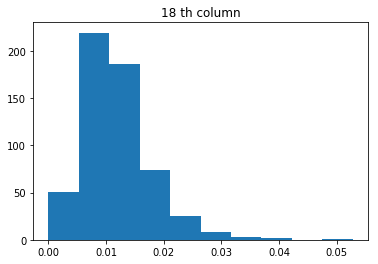

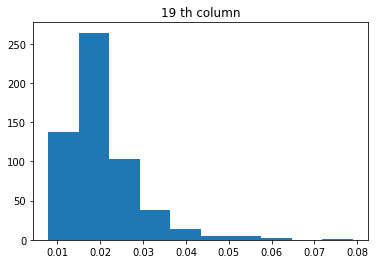

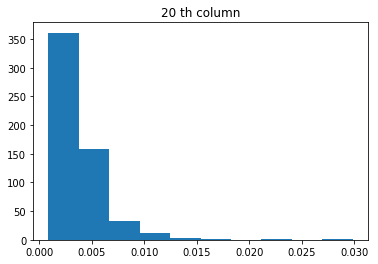

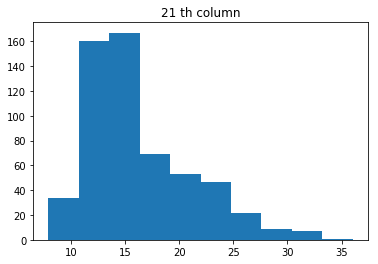

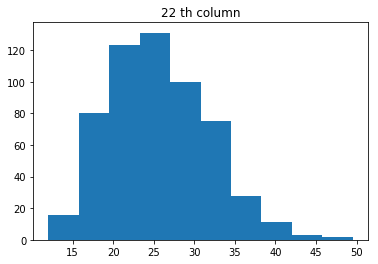

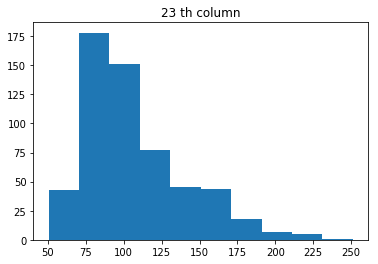

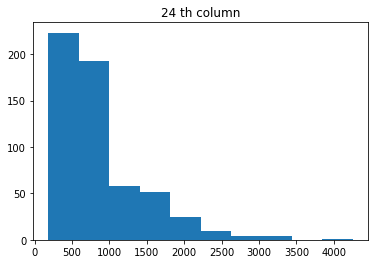

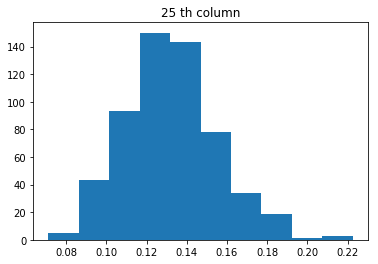

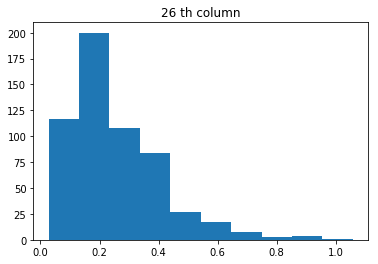

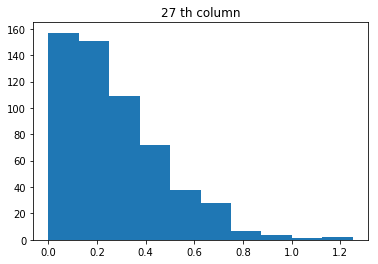

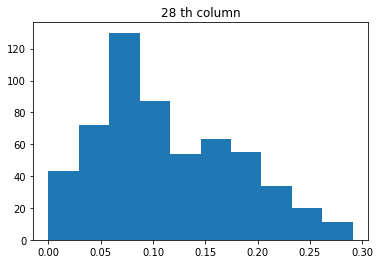

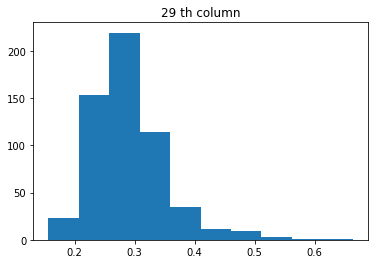

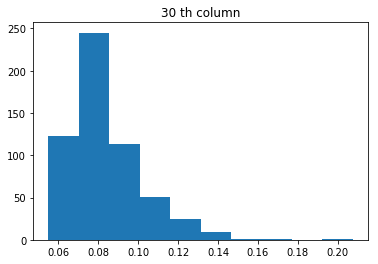

In [258]:
wdbc_preprocessed = preprocess("wdbc.data", "numeric", class_loc = 2, contains_id = True)
for i in range(len(wdbc_preprocessed[0].columns)-1):
    plt.figure(i)
    plt.title("%d th column" %(i+1))
    plt.hist(wdbc_preprocessed[0].iloc[:,i])

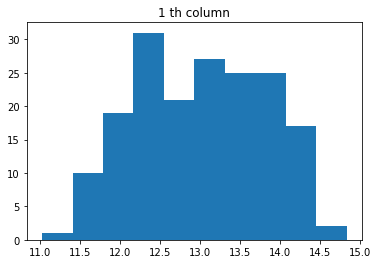

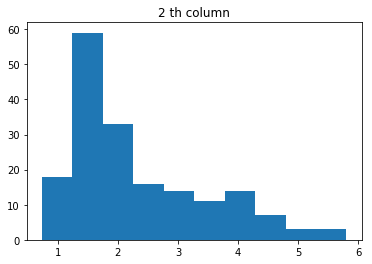

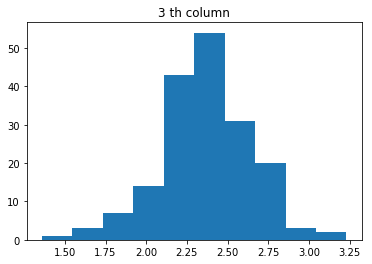

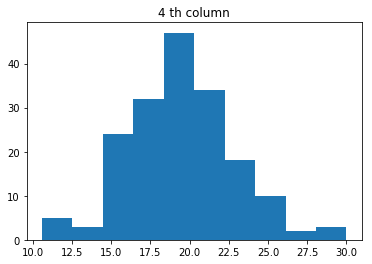

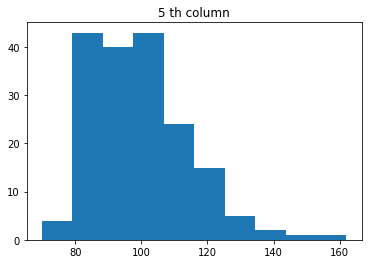

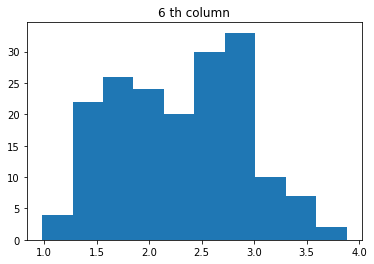

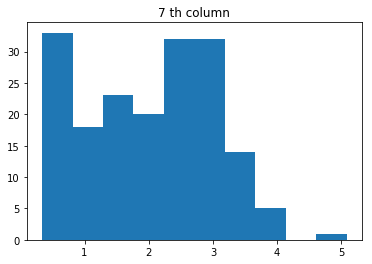

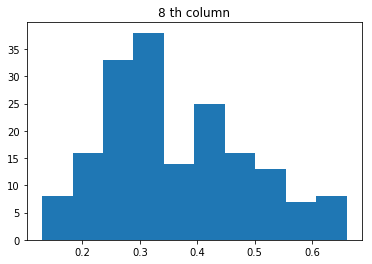

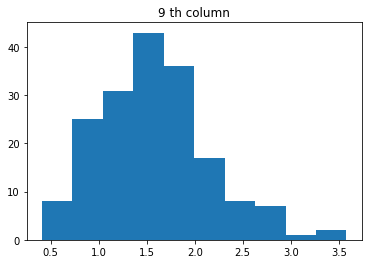

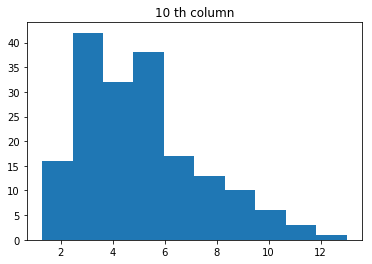

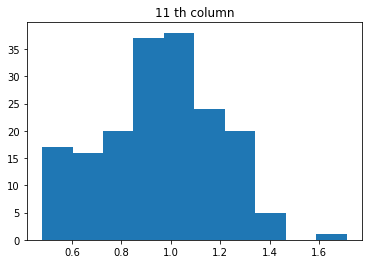

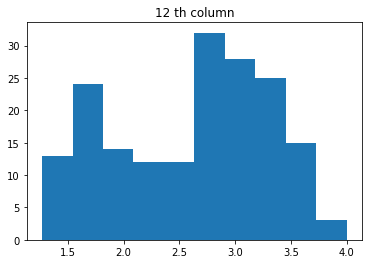

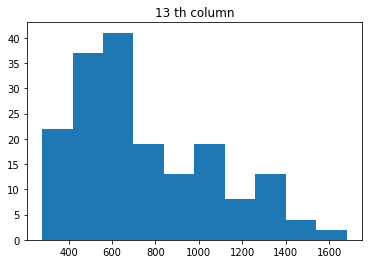

In [260]:
wine_preprocessed = preprocess("wine.data", "numeric", class_loc = 1)
for i in range(len(wine_preprocessed[0].columns)-1):
    plt.figure(i)
    plt.title("%d th column" %(i+1))
    plt.hist(wine_preprocessed[0].iloc[:,i], bins=10)

In [230]:
adult_attr_types = [2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0]
bank_attr_types = [2, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0]
uni_attr_types = [0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0]

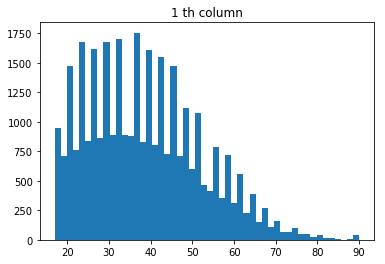

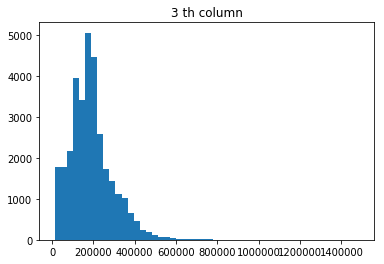

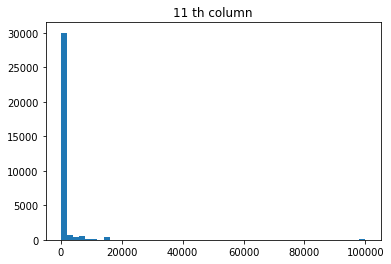

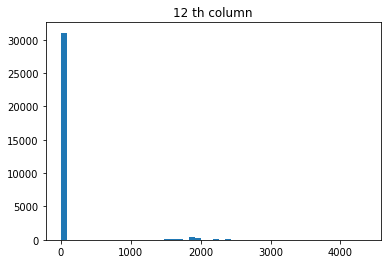

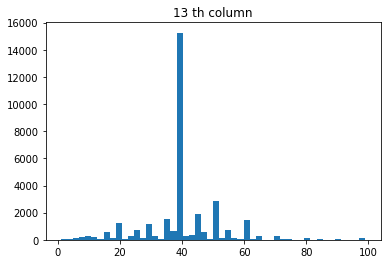

In [264]:
adult_preprocessed = preprocess("adult.data", "mixed", missing_value ='?')
for i in range(len(adult_attr_types)):
    if adult_attr_types[i] == 2:
        plt.figure(i)
        plt.title("%d th column" %(i+1))
        plt.hist(adult_preprocessed[0].iloc[:,i], bins=50)

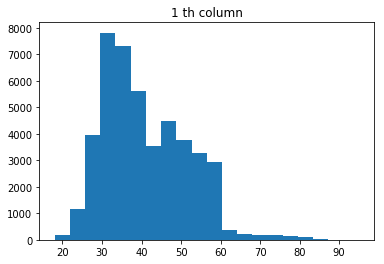

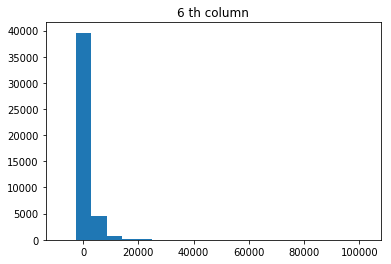

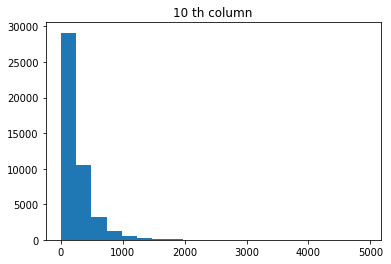

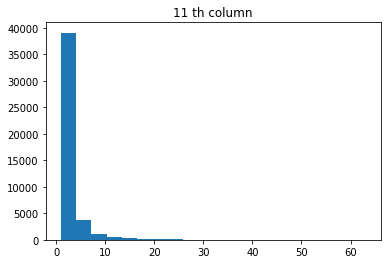

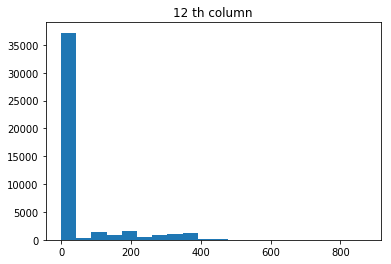

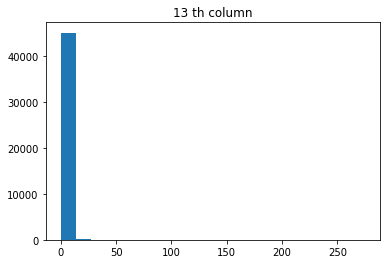

In [253]:
bank_preprocessed = preprocess("bank.data", "mixed")
for i in range(len(bank_attr_types)):
    if bank_attr_types[i] == 2:
        plt.figure(i)
        plt.title("%d th column" %(i+1))
        plt.hist(bank_preprocessed[0].iloc[:,i], bins = 20)

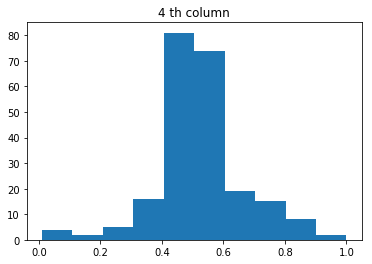

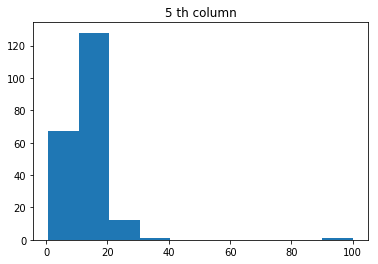

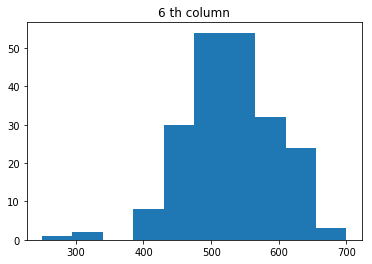

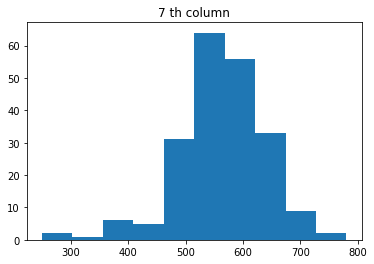

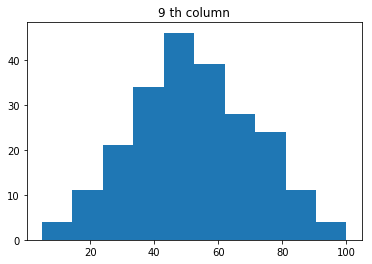

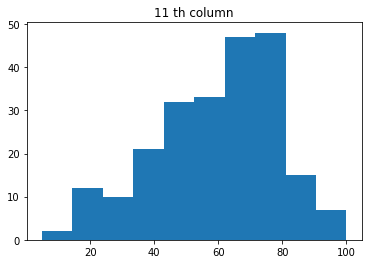

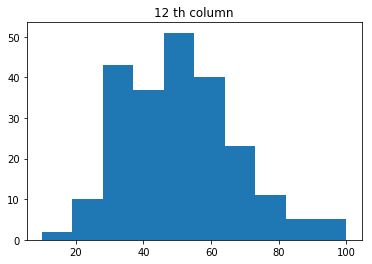

In [261]:
uni_preprocessed = preprocess("university.data", "mixed", contains_id=True, class_loc=15, missing_value=0)
for i in range(len(uni_attr_types)):
    if uni_attr_types[i] == 2:
        plt.figure(i)
        plt.title("%d th column" %(i+1))
        plt.hist(uni_preprocessed[0].iloc[:,i], bins = 10)

### Question 2

In [265]:
trained_sets = []
predicted_sets = []
eval_sets = []

for train_set, attr_type in preprocessed_files:
    trained_item = train(train_set, attr_type)
    trained_sets += [trained_item]
    predicted_item = predict(trained_item, train_set, attr_type, question_two = True)
    predicted_sets += [predicted_item]
    eval_sets += [evaluate(predicted_item, get_class_col(train_set))]


acc_dictionary = {'breast': eval_sets[0][0],
                  'mushroom': eval_sets[1][0],
                  'lymphography': eval_sets[2][0],
                  'wdbc': eval_sets[3][0],
                  'wine': eval_sets[4][0],
                  'car': eval_sets[5][0],
                  'nursery':eval_sets[6][0],
                  'somerville':eval_sets[7][0],
                  'adult':eval_sets[8][0],
                  'bank':eval_sets[9][0],
                  'uni': eval_sets[10][0]}
result_zero_r = pd.DataFrame(list(acc_dictionary.items()), columns = ['Data', '0-R Accuracy']).set_index('Data')

cf_matrix_zero_r = {'breast': eval_sets[0][1],
                  'mushroom': eval_sets[1][1],
                  'lymphography': eval_sets[2][1],
                  'wdbc': eval_sets[3][1],
                  'wine': eval_sets[4][1],
                  'car': eval_sets[5][1],
                  'nursery':eval_sets[6][1],
                  'somerville':eval_sets[7][1],
                  'adult':eval_sets[8][1],
                  'bank':eval_sets[9][1],
                  'uni': eval_sets[10][1]}

In [271]:
result['0-R Accuracy'] = result_zero_r['0-R Accuracy']
result['Difference'] = result['NB Accuracy'] - result_zero_r['0-R Accuracy']

In [273]:
result.T

Data,breast,mushroom,lymphography,wdbc,wine,car,nursery,somerville,adult,bank,uni
NB Accuracy,0.975680,0.965411,0.891892,0.940246,0.988764,0.873843,0.903086,0.671329,0.828169,0.877065,0.805195
0-R Accuracy,0.655222,0.517971,0.547297,0.627417,0.398876,0.700231,0.333333,0.538462,0.759190,0.883015,0.489177
Difference,0.320458,0.447440,0.344595,0.312830,0.589888,0.173611,0.569753,0.132867,0.068978,-0.005950,0.316017


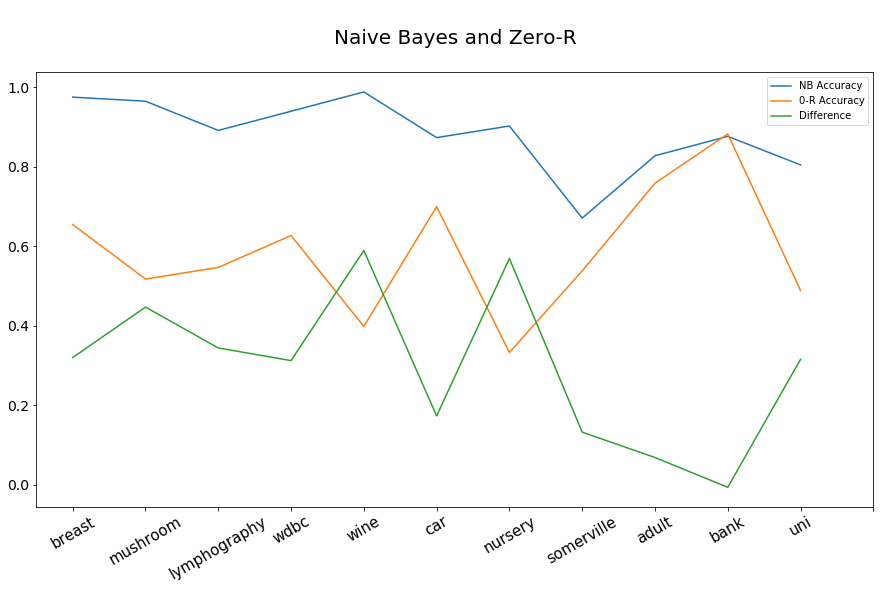

In [275]:
plt.rcParams["figure.figsize"] = (15,8)

result.plot()
plt.xlabel('')
plt.title('\nNaive Bayes and Zero-R\n', fontsize=20)

plt.xticks(rotation =30, fontsize = 15)
plt.yticks(fontsize=14)
plt.xticks(range(12),list(result.index))
plt.savefig('NB_zero-R.png', bbox_inches='tight')
plt.show()


## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1 - chosen
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

### Q2 - chosen
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

### Q3
Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as either nominal variables or numeric variables. Compare these strategies on the ordinal datasets provided. Deterimine which approach gives higher classification accuracy and discuss why.

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

### Q6
The Gaussian na¨ıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in these datasets? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the NB classifier’s predictions.